#  Machine learning assisted sensing of biomolecules by means of Raman spectroscopy

## Analysis of infected and non-infected blood serum

This dataset is part of the Research Data Support service campaign of open data by Springer Nature™ with the goal of making COVID-19 research free to access. It means that this data has not been yet officially published, but that the data used for it was published while the peer-review process goes on.

The dataset contains the spectra from the blood serum samples obtained from 53 confirmed SARS-CoV-2 infected patients, 50 non-infected patients, and 54 suspected unknown infection status.

Data: https://springernature.figshare.com/articles/Data_and_code_on_serum_Raman_spectroscopy_as_an_efficient_primary_screening_of_coronavirus_disease_in_2019_COVID-19_/12159924/1

### Read the samples
The samples are contained in a single file, it also contains the reference value for predicting on it under the `diagnostic` column.

To read the data we first need to create an Spectra object, which will contain all the spectroscopy samples and which contains the pre-processing methods, and then use the `readFile` method specifying the Spectra object in which to put the spectroscopy data.

```
spectra = rpy.Spectra()
to_predict = rpy.readFile(source_file, spectra_object, contains_reference_values)
```

In [3]:
# Libraries needed
import numpy as np
import ramanpy as rpy
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore") # To ignore annoying warnings on deprecations that third-party libraries perform

In [4]:
# Read spectroscopy data
spectra = rpy.Spectra()
to_predict = rpy.readFile("measurements/covid_and_healthy_spectra.csv", spectra, True)

+-----+-----+-----+-----+-----+-----+------+------+------+------+------------+
| 400 | 402 | 405 | 407 | 410 | ... | 2108 | 2109 | 2111 | 2112 | diagnostic |
+-----+-----+-----+-----+-----+-----+------+------+------+------+------------+
+-----+-----+-----+-----+-----+-----+------+------+------+------+------------+
Are the X values distributed in multiple columns? Yes/No [Yes]: 
Start column of X values? 400
End column of X values? 2112
Name of column containing the to-predict values: diagnostic


### Plot of mean with standard deviation for Infected and Non-Infected
First, we plot the mean and standard deviation of both infected and non-infected patients to observe if there are any visual differences between the two. Initially we took notes on the standard deviation that some peaks were showing (e.g. position $800 cm^{-1}$).

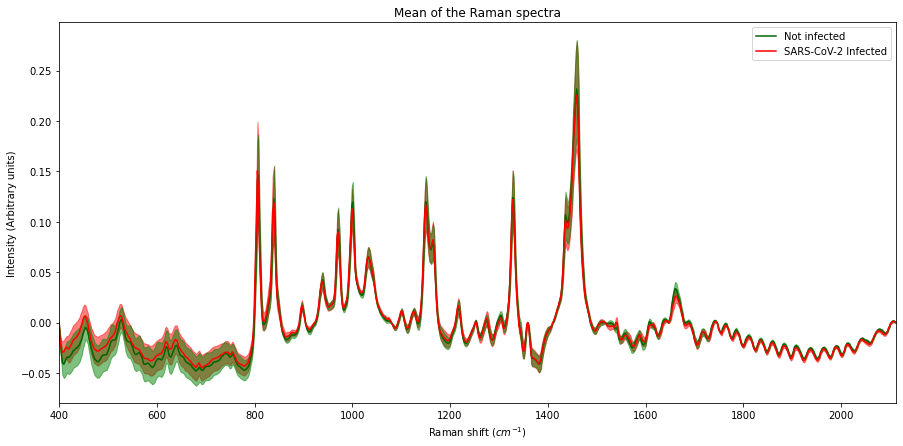

In [40]:
healthy = spectra.intensity[(to_predict == "Healthy").reshape(-1)].astype(np.float64)
infected = spectra.intensity[(to_predict == "SARS-CoV-2").reshape(-1)].astype(np.float64)

plt.figure(figsize=(15,7))
plt.plot(spectra.wavenumbers, np.mean(healthy, axis=0), label="Not infected", color="darkgreen")
plt.plot(spectra.wavenumbers, np.mean(infected, axis=0), label="SARS-CoV-2 Infected", color="r")
plt.fill_between(spectra.wavenumbers, infected.mean(axis=0) - infected.std(axis=0), infected.mean(axis=0) + infected.std(axis=0), alpha=0.5, color="r")
plt.fill_between(spectra.wavenumbers, healthy.mean(axis=0) - healthy.std(axis=0), healthy.mean(axis=0) + healthy.std(axis=0), alpha=0.5, color="g")

plt.title("Mean of the Raman spectra")
plt.xlabel("Raman shift ($cm^{-1}$)")
plt.ylabel("Intensity (Arbitrary units)")
plt.xlim([spectra.wavenumbers.min(), spectra.wavenumbers.max()])
plt.legend()
plt.grid(False)

### Select best classifier
Since the data is already pre-processed, there's no need to smooth or perform baseline removal. Then, the following step is to see which of the classifiers, KNN or SVM, after performing scaling, yields the best results.

Fitting 10 folds for each of 142 candidates, totalling 1420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

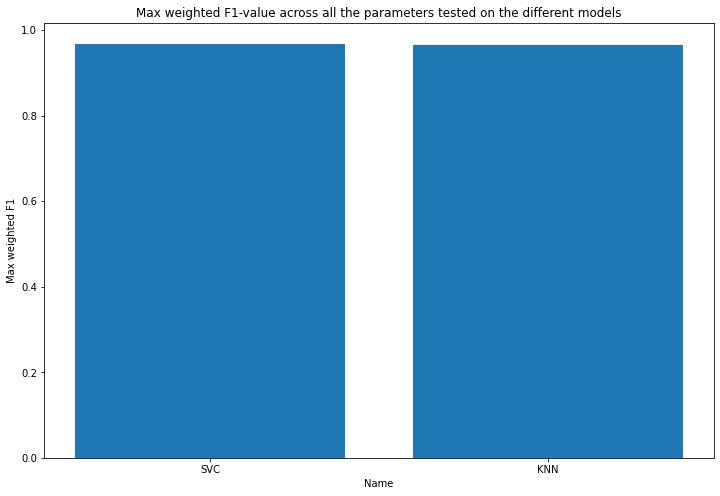

In [4]:
spectra.testClassifiers(to_predict, True)

### Train the model
The model with the best hyperparameters were selected from the step before using cross-validation. Now, the different metrics are presented by finally using the model.

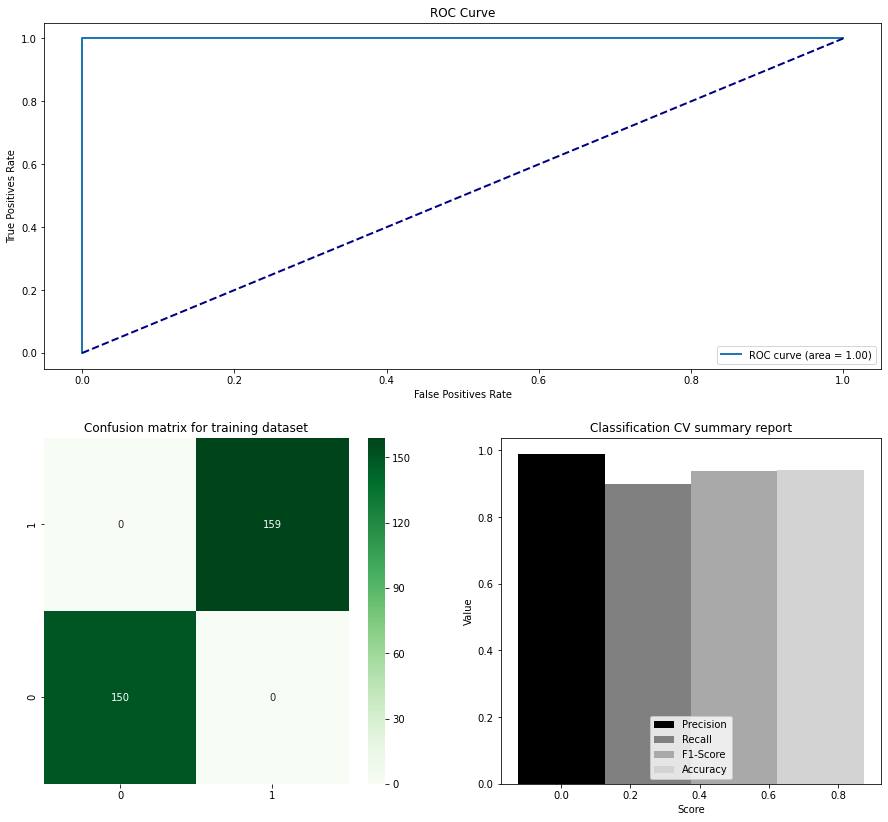

In [5]:
results = spectra.trainModel(to_predict, True)

### Variation of the results depending on different frequency ranges
The yielded results can be seen in the figure above. These were unbelieavably good. For this reason, we wanted to observe which Raman shifts were providing the most weights to these results.

In the figures below we can see, for example, that the accuracy is never lower than 80% in any of the 50 small ranges of 21 points that the samples were split into. This made us believe that the data might have something that is intrinsically wrong.

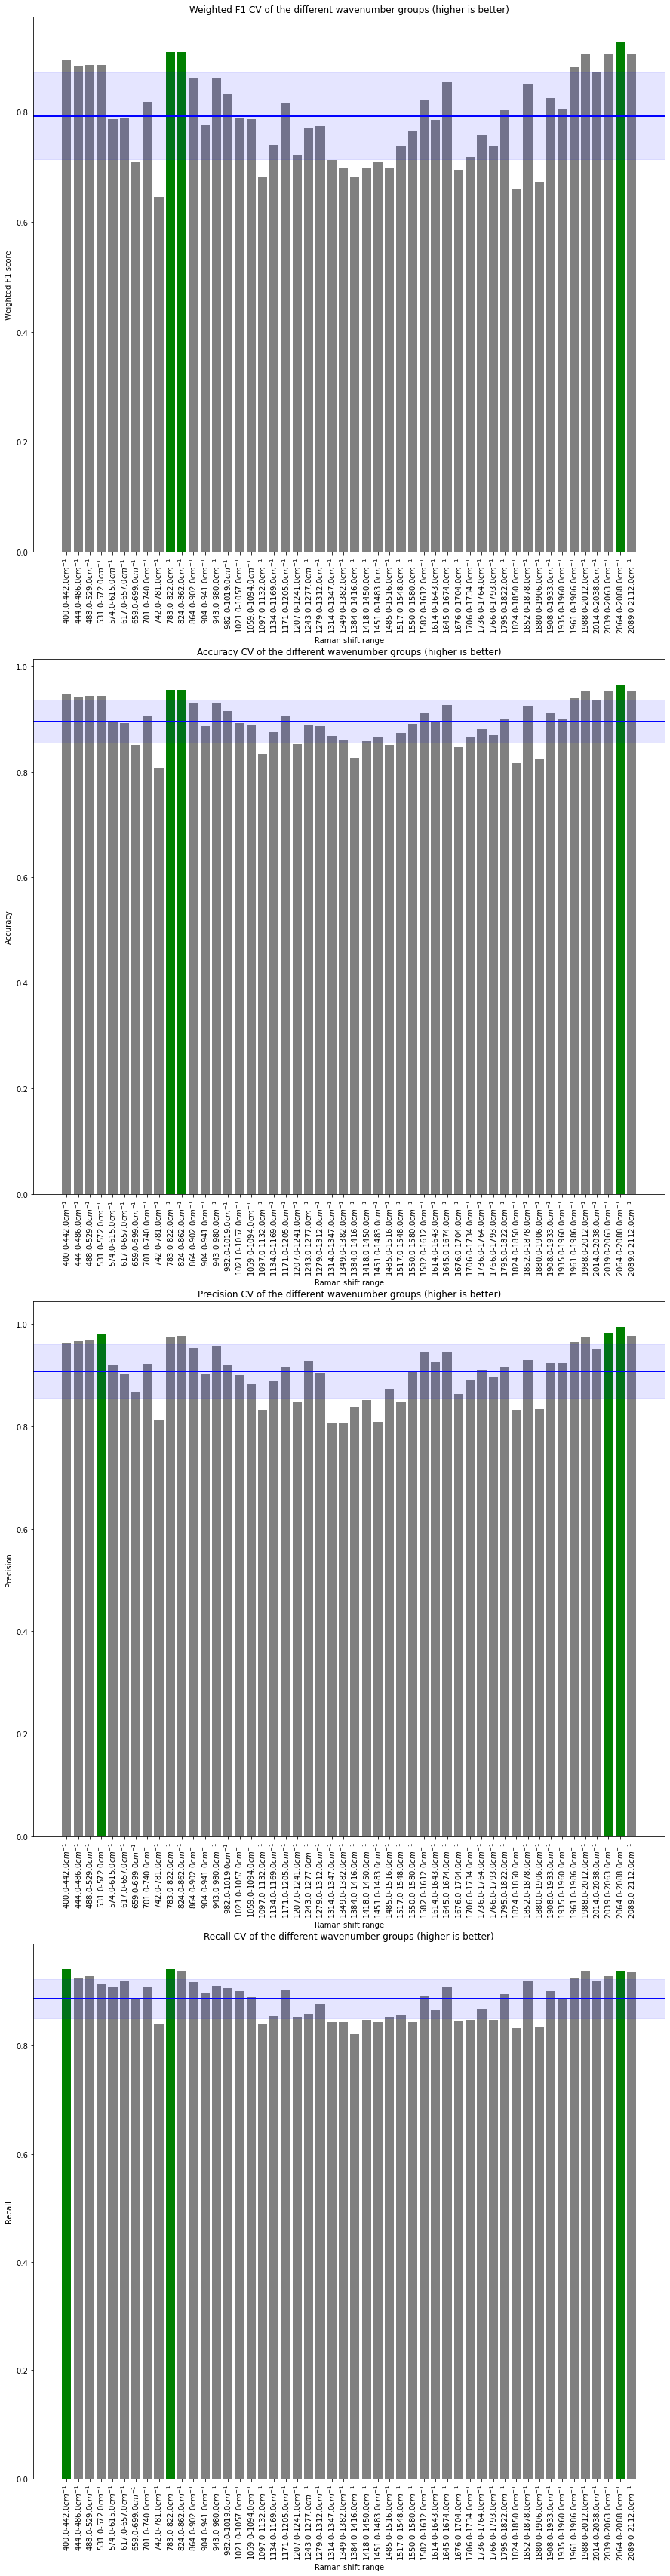

In [15]:
spectra.resultsIsolatedFrequencies(to_predict, 50)

#### Results on the CV metrics
The order in which they are printed is: `PRECISION, RECALL, F1, ACCURACY`.

In [6]:
model = spectra._model[1]
cv = 10
p = cross_val_score(model, results['X_train'], results['Y_train'], scoring='precision', cv = cv).mean()
r = cross_val_score(model, results['X_train'], results['Y_train'], scoring='recall', cv = cv).mean()
f1 = cross_val_score(model, results['X_train'], results['Y_train'], scoring='f1_weighted', cv = cv).mean()
a = cross_val_score(model, results['X_train'], results['Y_train'], scoring='accuracy', cv = cv).mean()
print(p, r, a, f1)

0.9882352941176471 0.8995833333333334 0.9418279569892473 0.938478022718846


### Principal Component Analysis of the data
PCA would allow us to observe which component splits the data perfectly into infected and non-infected, and therefore the weights of maximum importance in these principal components are the root of this difference.

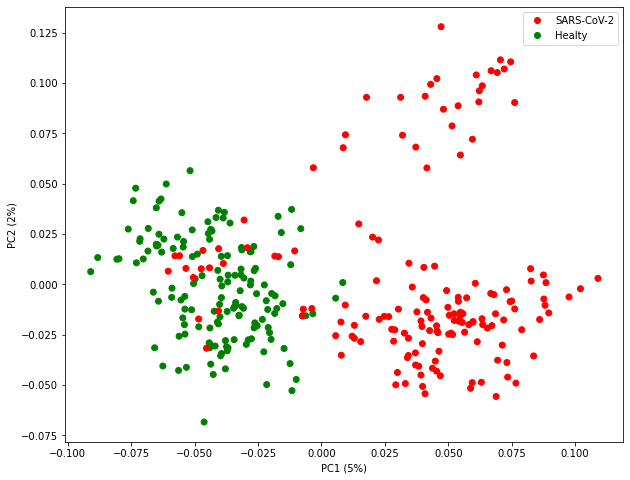

In [63]:
# Split into healthy and infected
healthy = spectra[to_predict == "Healthy"].index
sick = spectra[to_predict == "SARS-CoV-2"].index

# Calculate the PCA with 5 PCs
pca = PCA(n_components = 5, svd_solver = "full")
allvs = pca.fit_transform(spectra.values)

# Plot a figure with 4 subplot
plt.figure(figsize=(15,32))
plt.subplot(2, 2, 1)
plt.scatter(allvs[:, 3], allvs[:, 4], color = ["green" if to_predict[x] == "Healthy" else "red" for x in range(len(allvs))])
plt.xlabel(f"PC1 ({int(pca.explained_variance_ratio_[2]*100)}%)")
plt.ylabel(f"PC2 ({int(pca.explained_variance_ratio_[3]*100)}%)")
red_patch = mlines.Line2D([], [], color='red', label='SARS-CoV-2', marker=".", linestyle="None", markersize=12)
green_patch = mlines.Line2D([], [], color='green', label='Healty', marker=".", linestyle="None", markersize=12)
plt.legend(handles=[red_patch, green_patch])

plt.subplot(2, 2, 2)
plt.scatter(allvs[:, 2], allvs[:, 1], color = ["green" if to_predict[x] == "Healthy" else "red" for x in range(len(allvs))])
plt.xlabel(f"PC3 ({int(pca.explained_variance_ratio_[2]*100)}%)")
plt.ylabel(f"PC2 ({int(pca.explained_variance_ratio_[1]*100)}%)")
red_patch = mlines.Line2D([], [], color='red', label='SARS-CoV-2', marker=".", linestyle="None", markersize=12)
green_patch = mlines.Line2D([], [], color='green', label='Healty', marker=".", linestyle="None", markersize=12)
plt.legend(handles=[red_patch, green_patch])

plt.subplot(2, 2, 3)
plt.scatter(allvs[:, 0], allvs[:, 2], color = ["green" if to_predict[x] == "Healthy" else "red" for x in range(len(allvs))])
plt.xlabel(f"PC1 ({int(pca.explained_variance_ratio_[0]*100)}%)")
plt.ylabel(f"PC3 ({int(pca.explained_variance_ratio_[2]*100)}%)")
red_patch = mlines.Line2D([], [], color='red', label='SARS-CoV-2', marker=".", linestyle="None", markersize=12)
green_patch = mlines.Line2D([], [], color='green', label='Healty', marker=".", linestyle="None", markersize=12)
plt.legend(handles=[red_patch, green_patch])

plt.subplot(2, 2, 4)
plt.scatter(allvs[:, 0], allvs[:, 3], color = ["green" if to_predict[x] == "Healthy" else "red" for x in range(len(allvs))])
plt.xlabel(f"PC1 ({int(pca.explained_variance_ratio_[0]*100)}%)")
plt.ylabel(f"PC4 ({int(pca.explained_variance_ratio_[3]*100)}%)")
red_patch = mlines.Line2D([], [], color='red', label='SARS-CoV-2', marker=".", linestyle="None", markersize=12)
green_patch = mlines.Line2D([], [], color='green', label='Healty', marker=".", linestyle="None", markersize=12)
plt.legend(handles=[red_patch, green_patch])

#### Weights of the Principal Components 1, 2, 3 and 4

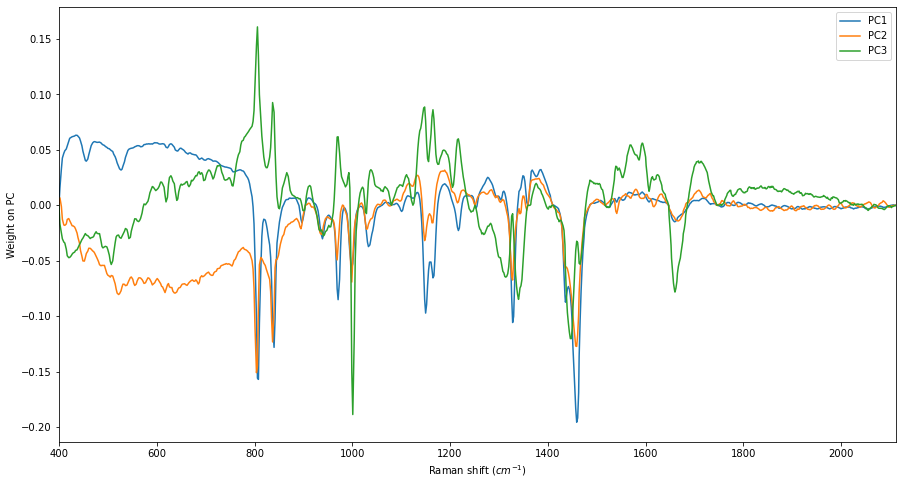

In [20]:
plt.figure(figsize=(15,8))
plt.plot(spectra.wavenumbers, pca.components_[0], label="PC1")
plt.plot(spectra.wavenumbers, pca.components_[1], label="PC2")
plt.plot(spectra.wavenumbers, pca.components_[2], label="PC3")
plt.plot(spectra.wavenumbers, pca.components_[2], label="PC4")
plt.xlim([spectra.wavenumbers.min(), spectra.wavenumbers.max()])
plt.xlabel("Raman shift ($cm^{-1}$)")
plt.ylabel("Weight on PC")
plt.legend()

### LDA Clustering
Linear Discriminant Analysis was performed to observe if LDA was able to differentiate the two classes more easily than PCA, which it did, due to the nature of LDA it was only possible to plot against 1 PC.

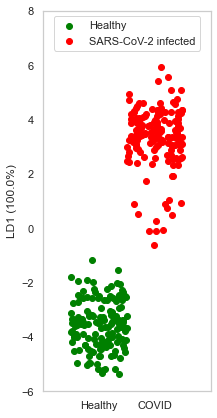

In [240]:
lda = LinearDiscriminantAnalysis(n_components = 5, store_covariance=True)
X_r2 = lda.fit(spectra.intensity, to_predict).transform(spectra.intensity)
plt.figure(figsize=(3,7))
ax = plt.subplot(111)
plt.scatter(np.zeros_like(X_r2[to_predict == "Healthy"]) + np.random.rand(X_r2[to_predict == "Healthy"].shape[0])*0.3-(0.3/2), X_r2[to_predict == "Healthy"], color="green", label="Healthy")
plt.scatter(np.ones_like(X_r2[to_predict == "SARS-CoV-2"])*0.3 + np.random.rand(X_r2[to_predict == "SARS-CoV-2"].shape[0])*0.3-(0.3/2), X_r2[to_predict == "SARS-CoV-2"], color="red", label="SARS-CoV-2 infected")
ax.set_xticks((0, 0.3))
ax.set_xticklabels(["Healthy", "COVID"])
ax.set_ylabel(f"LD1 ({lda.explained_variance_ratio_[0]*100}%)")
ax.set_xlim([-0.3, 0.6])
ax.set_ylim([-6, 8])
ax.legend(loc="upper center")
ax.grid(False)
plt.show()

### Re-evaluating the mean-centered data
In a meeting with Rodrigo Watté we discovered that the data is actually shifted between the two groups, this shift could explain the reason why the results for smaller sections of the signals were providing such good results still.

The reason for this shift could be due to multiple reasons, but our first hypothesis is an error in the design of the experiment.

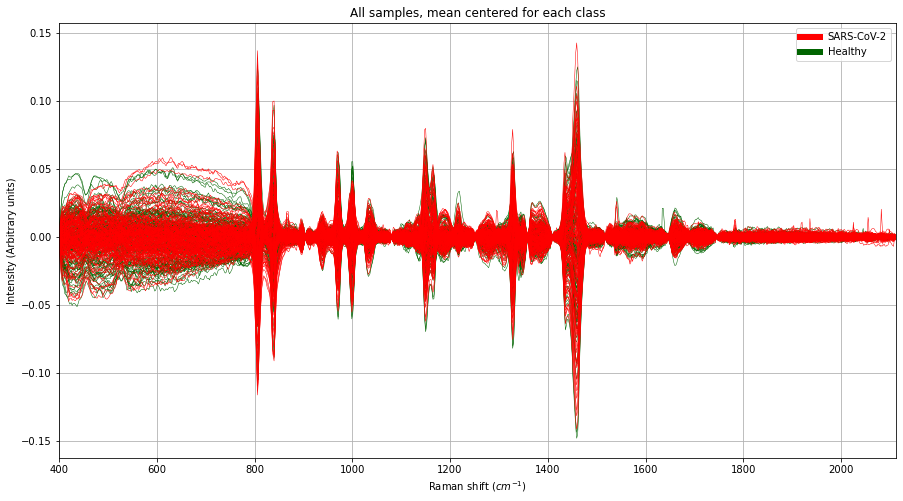

In [13]:
plt.figure(figsize=(15,8))
mean_h = spectra[to_predict == "Healthy"].intensity.mean()
mean_c = spectra[to_predict == "SARS-CoV-2"].intensity.mean()
for position in spectra[to_predict == "Healthy"].index:
    plt.plot(spectra.wavenumbers, (spectra.intensity[position] - spectra[to_predict == "Healthy"].intensity.mean(axis=0)), color = "darkgreen", alpha = 1, linewidth=0.5)
for position in spectra[to_predict == "SARS-CoV-2"].index:
    plt.plot(spectra.wavenumbers, spectra.intensity[position] - spectra[to_predict == "SARS-CoV-2"].intensity.mean(axis=0), color = "red", alpha = 1, linewidth=0.5)

plt.grid(True)
plt.xlim([400,2112])
red_patch = mlines.Line2D([], [], color='red', label='SARS-CoV-2', linestyle="-", markersize=12, linewidth=6)
green_patch = mlines.Line2D([], [], color='darkgreen', label='Healthy', linestyle="-", markersize=12, linewidth=6)
plt.legend(handles=[red_patch, green_patch])
plt.title("All samples, mean centered for each class")
plt.xlabel("Raman shift ($cm^{-1}$)")
plt.ylabel("Intensity (Arbitrary units)")

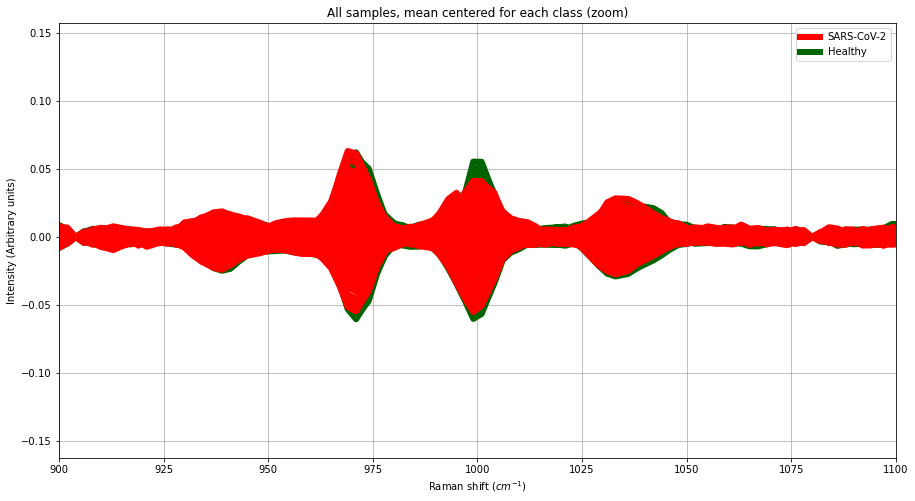

In [18]:
plt.figure(figsize=(15,8))
mean_h = spectra[to_predict == "Healthy"].intensity.mean(axis=0)
mean_c = spectra[to_predict == "SARS-CoV-2"].intensity.mean(axis=0)
for position in spectra[to_predict == "Healthy"].index:
    plt.plot(spectra.wavenumbers, (spectra.intensity[position] - spectra[to_predict == "Healthy"].intensity.mean(axis=0)), color = "darkgreen", alpha = 1, linewidth=6)
for position in spectra[to_predict == "SARS-CoV-2"].index:
    plt.plot(spectra.wavenumbers, spectra.intensity[position] - spectra[to_predict == "SARS-CoV-2"].intensity.mean(axis=0), color = "red", alpha = 1, linewidth=6)

plt.grid(True)
plt.xlim([900,1100])
red_patch = mlines.Line2D([], [], color='red', label='SARS-CoV-2', linestyle="-", markersize=12, linewidth=6)
green_patch = mlines.Line2D([], [], color='darkgreen', label='Healthy', linestyle="-", markersize=12, linewidth=6)
plt.legend(handles=[red_patch, green_patch])
plt.title("All samples, mean centered for each class (zoom)")
plt.xlabel("Raman shift ($cm^{-1}$)")
plt.ylabel("Intensity (Arbitrary units)")